# Experiments with the concatenated Shor code

In the following, a series of experiments will be performed to investigate the capacity of the concatenated Shor code for fault tolerant quantum computing. The concatenated Shor Code is the 9 qubit Shor Code concatenated with itself yielding $[[9^n, 1, 3^n]]$ quantum error correction codes where $n$ is the level of concatenation and $n=1$ is the usual 9 qubit Shor code.

In [ ]:
#Import needed packages
from shor_code_package.shor_code import ConcatenatedShorQubit, ShorCircuit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, generate_preset_pass_manager
import qiskit.quantum_info as qi
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (NoiseModel, ReadoutError, pauli_error)
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import pickle

## Error correction capabilities of the concatenated Shor code

In [2]:
class NoiseModelExperiment:
    def __init__(self, qc, noise_model_generator, noise_model_generator_inputs, shots = 1000, silent = True, method = 'stabilizer', **kwargs):
        self.noise_model_generator = noise_model_generator
        self.inputs = noise_model_generator_inputs
        self.output = []
        self.aer = AerSimulator(method = method, **kwargs)
        self.shots = shots

        #Transpile the circuit for the simulator
        pass_manager = generate_preset_pass_manager(1, self.aer) #Optimization level = 1 or else it won't work.
        self.qc = pass_manager.run(qc)
        self.silent = silent

    def run(self):
        for index, input in enumerate(self.inputs):
            noise_model = self.noise_model_generator(input)
            self.aer.set_option("noise_model", noise_model)
            run = self.aer.run(self.qc, shots = self.shots)
            self.output.append(run.result())
            if not self.silent:
                print(f"Simulation {index} of {len(self.inputs)} done.", end = "\r")
        return self.output

In [62]:
#The experiment is repeated for each of the Pauli operator eigenbases 
results = dict()
for experiment in ['X','Y','Z','high_res_x','high_res_z', 'high_res_y', 'zoom_x', 'zoom_z', 'zoom_y']:
    n = 1
    if experiment == 'high_res_x':
        inputs = [(px, 0, 0) for px in np.linspace(0, 1, 300)]
    elif experiment == 'high_res_z':
        inputs = [(0, pz, 0) for pz in np.linspace(0, 1, 300)]
    elif experiment == 'high_res_y':
        inputs = [(0, 0, py) for py in np.linspace(0, 1, 300)]
    elif experiment == 'zoom_x':
        inputs = [(px, 0, 0) for px in np.linspace(0, 0.05, 100)]
    elif experiment == 'zoom_z':
        inputs = [(0, pz, 0) for pz in np.linspace(0, 0.05, 100)]
    elif experiment == 'zoom_y':
        inputs = [(0, 0, py) for py in np.linspace(0, 0.05, 100)]
    else:
        inputs = [(px, pz, 0) for px in np.linspace(0, 0.33, 15) for pz in np.linspace(0, 0.33, 15)]
    shots = 2e3
    num_qubits = 9**n

    #Set up circuit
    shor_circuit = ShorCircuit([n])
    state_prep = QuantumCircuit(num_qubits + 1)
    #Convert to desired basis
    if experiment == "X":
        state_prep.h(0)
    elif experiment not in ['Z']:
        state_prep.h(0)
        state_prep.s(0)
    shor_circuit._circuit.compose(state_prep, front=True, inplace=True)

    #Add circuit for introducing error
    shor_circuit._circuit.add_register(QuantumRegister(1))
    error_circuit = QuantumCircuit(num_qubits + 2)
    for q in range(num_qubits):
        #These are the gates introducing error
        error_circuit.cx(num_qubits+1, q)
    shor_circuit._circuit.compose(error_circuit, inplace=True)

    #Correct the error
    shor_circuit.error_correct(0)
    shor_circuit.decoder(0)

    qc = shor_circuit.get_circuit()
    #Transform back to Z basis
    if experiment == "X":
        qc.h(0)
    elif experiment not in ['Z']:
        qc.sdg(0)
        qc.h(0)

    #Measure
    output_register = ClassicalRegister(1)
    qc.add_register(output_register)
    qc.measure(0, output_register)

    #Define noise model
    def noise_model_generator(input):
        #Set up noise model
        px, pz, py = input
        x_error = pauli_error([('II', 1-(px)),('XI', px)]) #X I = Target Control
        z_error = pauli_error([('II', 1-(pz)),('ZI', pz)])
        y_error = pauli_error([('II', 1-(py)),('YI', py)])
        error = x_error.compose(z_error.compose(y_error))
        noise_model = NoiseModel()
        for q in range(num_qubits):
            noise_model.add_quantum_error(error, ['cx'], [num_qubits+1, q]) #The error is applied after applying an entangling gate from an unused ancilla.
        return noise_model

    #Simulate
    noise_model_experiment = NoiseModelExperiment(qc, noise_model_generator, inputs, shots=shots, silent = False)
    result = noise_model_experiment.run()
    results[experiment] = result



In [63]:
#Post process simulation results
post_processed_n_1 = dict()
for key, result in list(results.items())[:3]:
    fidelities = [sum([experiment.get_counts()[key] for key in experiment.get_counts().keys() if key.startswith('0')])/shots for experiment in result]
    fidelities_grid = np.reshape(fidelities, (15,15))
    post_processed_n_1[key] = fidelities_grid

for key, result in list(results.items())[3:]:
    fidelities = [sum([experiment.get_counts()[key] for key in experiment.get_counts().keys() if key.startswith('0')])/shots for experiment in result]
    post_processed_n_1[key] = fidelities

# Save dictionary to file
post_processed_n_1["high_res_ps"] = np.linspace(0, 1, 300)
post_processed_n_1["zoom_ps"] = np.linspace(0, 0.05, 100)
post_processed_n_1["square_ps"] = np.linspace(0, 0.33, 15)

with open('data/n1.pkl', 'wb') as file:
    pickle.dump(post_processed_n_1, file)


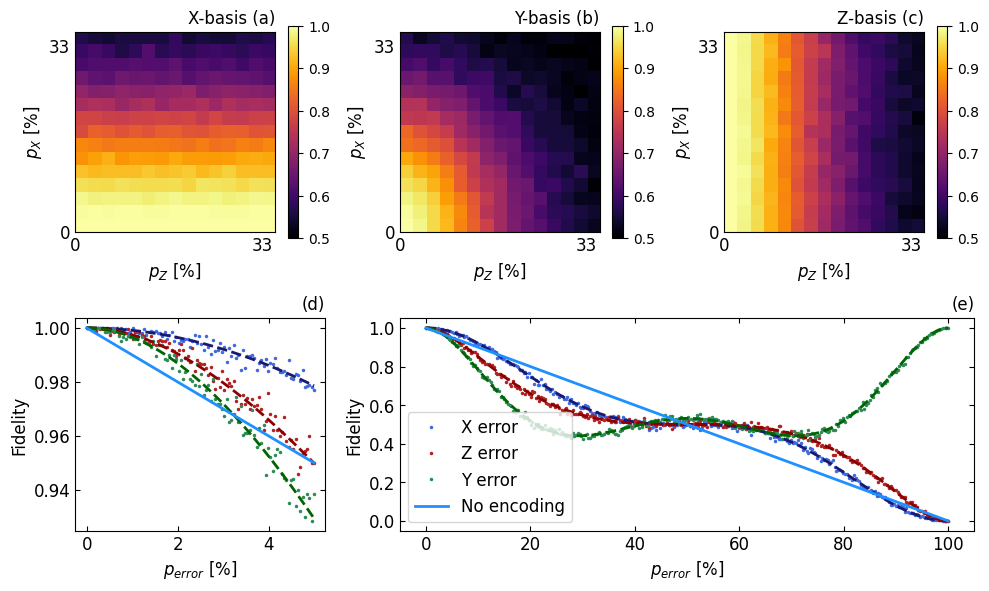

In [102]:
# Reading dictionary
with open('data/n1.pkl', 'rb') as file:
    post_processed_n_1 = pickle.load(file)

plt.figure(figsize=(10,6))

rows_cols = (2,6)
ax21 = plt.subplot2grid(rows_cols, (1,0), colspan=2)
ax22 = plt.subplot2grid(rows_cols, (1,2), colspan=4)
ax11 = plt.subplot2grid(rows_cols, (0,0), colspan=2)
ax12 = plt.subplot2grid(rows_cols, (0,2), colspan=2)
ax13 = plt.subplot2grid(rows_cols, (0,4), colspan=2)
axs = [ax21, ax22, ax11, ax12, ax13]

for ax in axs:
    ax.tick_params(direction='in', left=True, right=True, top=True, bottom=True)

#Plot data
im1 = axs[2].imshow(post_processed_n_1["X"], cmap='inferno', origin="lower", vmin=0.5)
plt.colorbar(im1)

im2 = axs[3].imshow(post_processed_n_1["Y"], cmap='inferno', origin="lower", vmin=0.5)
plt.colorbar(im2)

im3=axs[4].imshow(post_processed_n_1["Z"], cmap='inferno', origin="lower", vmin=0.5)
plt.colorbar(im3)


#Plot theoretical curves
ps = post_processed_n_1['high_res_ps']
p3x = lambda p: (1-p)**3 + 3*p*(1-p)**2
p9x = lambda p: p3x(p)**3 + 3*p3x(p)*(1-p3x(p))**2
p3z = lambda p: (1-p)**3 + 3*p**2*(1-p)
p9z = lambda p: p3z(p)**3 + 3*p3z(p)**2*(1-p3z(p))
p_y = lambda p: (1-p)**9 + 9*p*(1-p)**8 + 126*p**4*(1-p)**5 + 126*p**5*(1-p)**4 + 9*(1-p)*p**8 + p**9 

ax22.plot(ps*100,post_processed_n_1["high_res_x"], label='X error', color='royalblue', marker='.', markersize=3, linestyle='none')
ax22.plot(ps*100,post_processed_n_1["high_res_z"], label='Z error', color='firebrick', marker='.', markersize=3, linestyle='none')
ax22.plot(ps*100,post_processed_n_1["high_res_y"], label='Y error', color='seagreen', marker='.', markersize=3, linestyle='none')

ax22.plot(ps*100,1- ps, label='No encoding', linestyle='-', color='dodgerblue', zorder=5000, lw=2)
ax22.plot(ps*100,p9x(ps), color='midnightblue', linestyle='--', lw=2)
ax22.plot(ps*100,p9z(ps), color='darkred', linestyle='--',lw=2)
ax22.plot(ps*100, p_y(ps), color='darkgreen', linestyle='--',lw=2)

ps = post_processed_n_1['zoom_ps']
ax21.plot(ps*100,post_processed_n_1["zoom_x"], label='X error', color='royalblue', marker='.', markersize=3, linestyle='none')
ax21.plot(ps*100,post_processed_n_1["zoom_z"], label='Z error', color='firebrick', marker='.', markersize=3, linestyle='none')
ax21.plot(ps*100,post_processed_n_1["zoom_y"], label='Y error', color='seagreen', marker='.', markersize=3, linestyle='none')

ax21.plot(ps*100,1- ps, label='No encoding', linestyle='-', color='dodgerblue', zorder=5000, lw=2)
ax21.plot(ps*100, p9x(ps), color='midnightblue', linestyle='--', zorder=1000, lw=2)
ax21.plot(ps*100, p9z(ps), color='darkred', linestyle='--',zorder=1000, lw=2)
ax21.plot(ps*100, p_y(ps), color='darkgreen', linestyle='--',zorder=1000, lw=2)

for ax in axs[2:]:
    ax.set_xlabel("$p_Z$ [%]", size=12)
    ax.set_ylabel("$p_X$ [%]", size=12)
    ax.xaxis.set_major_locator(ticker.FixedLocator([-0.5, 13.5]))
    ax.yaxis.set_major_locator(ticker.FixedLocator([-0.5, 13.5]))
    ax.set_xticklabels(['0','33'], size=12)
    ax.set_yticklabels(['0','33'], size=12)
    ax.tick_params(size=0)
    
axs[2].set_title("X-basis (a)", loc="right", size=12)
axs[3].set_title("Y-basis (b)", loc="right", size=12)
axs[4].set_title("Z-basis (c)", loc="right", size=12)

for ax in [ax21, ax22]:
    ax.set_xlabel('$p_{error}$ [%]', size=12)
    ax.set_ylabel('Fidelity',size=12)
    ax.tick_params(labelsize=12)
ax21.set_title("(d)", loc="right", size=12)
ax22.set_title("(e)", loc="right", size=12)
ax22.legend(fontsize=12)
plt.tight_layout()
plt.savefig("figures/pauli_errors.pdf")

The experiment is repeated for $n=2$.

In [ ]:

results_n_2_new = dict()
for experiment in ['zoom_y']:#['high_res_x','high_res_z', 'high_res_y','zoom_y']:#, 'zoom_x', 'zoom_z', 'zoom_y']:
    n = 2
    if experiment == 'high_res_x':
        inputs = [(px, 0, 0) for px in np.linspace(0, 1/2, 50)]
    elif experiment == 'high_res_z':
        inputs = [(0, pz, 0) for pz in np.linspace(0, 1/2, 50)]
    elif experiment == 'high_res_y':
        inputs = [(0, 0, py) for py in np.linspace(0, 1/2, 50)]
    elif experiment == 'zoom_y':
        inputs = [(0, 0, py) for py in np.linspace(0, 0.10, 80)]
    shots = 1e3
    num_qubits = 9**n

    #Set up circuit
    shor_circuit = ShorCircuit([n])
    input_state_circuit = QuantumCircuit(num_qubits + 1)
    input_state_circuit.h(0)
    input_state_circuit.s(0)

    #Convert to Y basis
    shor_circuit._circuit.compose(input_state_circuit, front=True, inplace=True)

    #Add circuit for introducing error
    shor_circuit.add_register(QuantumRegister(1))
    error_circuit = QuantumCircuit(num_qubits + 2)
    for q in range(num_qubits):
        #These are the gates introducing error
        error_circuit.cx(num_qubits+1, q)
    shor_circuit._circuit.compose(error_circuit, inplace=True)

    #Correct the error
    shor_circuit.error_correct(0)

    #Transform back to Z basis
    shor_circuit.decoder(0)
    shor_circuit._circuit.compose(input_state_circuit.inverse(), inplace=True)

    qc = shor_circuit.get_circuit()

    #Measure
    output_register = ClassicalRegister(1)
    qc.add_register(output_register)
    qc.measure(0, output_register)

    #Define noise model
    def noise_model_generator(input):
        #Set up noise model
        px, pz, py = input
        x_error = pauli_error([('II', 1-(px)),('XI', px)]) #X I = Target Control
        z_error = pauli_error([('II', 1-(pz)),('ZI', pz)])
        y_error = pauli_error([('II', 1-(py)),('YI', py)])
        error = x_error.compose(z_error.compose(y_error))
        noise_model = NoiseModel()
        for q in range(num_qubits):
            noise_model.add_quantum_error(error, ['cx'], [num_qubits+1, q]) #The error is applied after applying an entangling gate from an unused ancilla.
        return noise_model

    #display(qc.draw(fold=-1))
    #Simulate
    noise_model_experiment = NoiseModelExperiment(qc, noise_model_generator, inputs, shots=shots, silent = False)
    result = noise_model_experiment.run()
    results_n_2_new[experiment] = result



In [43]:
#Post process simulation results
post_processed_n_2_new = dict()
for key, value in results_n_2_new.items():
    fidelities = [sum([experiment.get_counts()[k] for k in experiment.get_counts().keys() if k.startswith('0')])/shots for experiment in value]
    post_processed_n_2_new[key] = fidelities

# Save dictionary to file
post_processed_n_2_new["high_res_ps"] = np.linspace(0, 1/2, 50)
post_processed_n_2_new["zoom_ps"] = np.linspace(0, 0.10, 80)

with open('data/n2_new.pkl', 'wb') as file:
    pickle.dump(post_processed_n_2_new, file)

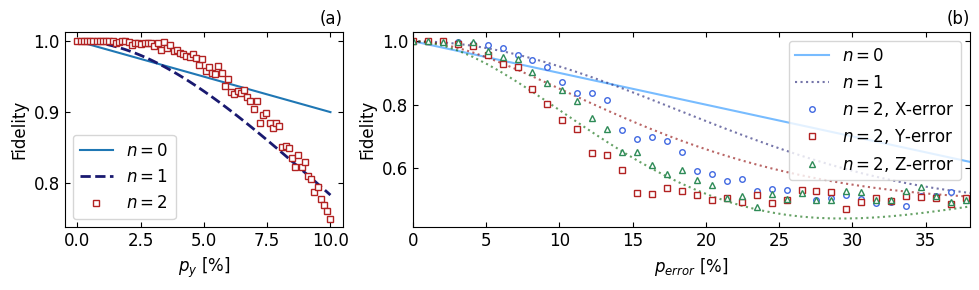

In [184]:
#Load data
with open('data/n1.pkl', 'rb') as file:
    post_processed_n_1 = pickle.load(file)
with open('data/n2.pkl', 'rb') as file:
    post_processed_n_2 = pickle.load(file)
with open('data/n2_new.pkl', 'rb') as file:
    post_processed_n_2_new = pickle.load(file)

#Theoretical models
p3x = lambda p: (1-p)**3 + 3*p*(1-p)**2
p9x = lambda p: p3x(p)**3 + 3*p3x(p)*(1-p3x(p))**2
p27x = lambda p: p3x(p9x(p))
p81x = lambda p: p9x(p27x(p))

p3z = lambda p: (1-p)**3 + 3*p**2*(1-p)
p9z = lambda p: p3z(p)**3 + 3*p3z(p)**2*(1-p3z(p))


p_y = lambda p: (1-p)**9 + 9*p*(1-p)**8 + 126*p**4*(1-p)**5 + 126*p**5*(1-p)**4 + 9*(1-p)*p**8 + p**9 
p_y_2 = lambda p: p_y(1-p_y(p))

#The figure
fig, axs = plt.subplots(1,2,figsize=(10,3), width_ratios=[1,2])
ax1, ax2 = axs

ax1.plot(post_processed_n_2_new['zoom_ps']*100, [1-p for p in post_processed_n_2_new['zoom_ps']], label='$n=0$')
ax1.plot(post_processed_n_2_new['zoom_ps']*100, p_y(post_processed_n_2_new['zoom_ps']), color='midnightblue', linestyle='--',zorder=1000, lw=2, label='$n=1$')
ax1.plot(post_processed_n_2_new['zoom_ps']*100, post_processed_n_2_new['zoom_y'], color='firebrick', marker='s', markerfacecolor='w', markersize=4, zorder=10000, linestyle='none', label='$n=2$')


ax2.plot(post_processed_n_2['high_res_ps']*100,1- post_processed_n_2['high_res_ps'], label='$n=0$', linestyle='-', color='dodgerblue', zorder=-5000, lw=1.5, alpha=0.6)
ax2.plot(post_processed_n_2['high_res_ps']*100, p9x(post_processed_n_2['high_res_ps']), color='midnightblue', markerfacecolor='w',linestyle=':', zorder=-1000, lw=1.5, alpha=0.6, label='$n=1$')
ax2.plot(post_processed_n_2['high_res_ps']*100, p9z(post_processed_n_2['high_res_ps']), color='darkred', markerfacecolor='w', linestyle=':',zorder=-1000, lw=1.5, alpha=0.6)
ax2.plot(post_processed_n_2['high_res_ps']*100, p_y(post_processed_n_2['high_res_ps']), color='darkgreen',markerfacecolor='w', linestyle=':',zorder=-1000, lw=1.5, alpha=0.6)
ax2.plot(post_processed_n_2['high_res_ps']*100, post_processed_n_2["high_res_x"], color='royalblue', marker='o', markerfacecolor='w', markersize=4, linestyle='none', label='$n=2$, X-error')
ax2.plot(post_processed_n_2['high_res_ps']*100, post_processed_n_2["high_res_y"], color='firebrick', marker='s', markerfacecolor='w', markersize=4, linestyle='none', label='$n=2$, Y-error')
ax2.plot(post_processed_n_2['high_res_ps']*100, post_processed_n_2["high_res_z"], color='seagreen', marker='^', markerfacecolor='w', markersize=4, linestyle='none', label='$n=2$, Z-error')

#Style
for ax in axs:
    ax.tick_params(direction='in', left=True, right=True, top=True, bottom=True, labelsize=12)
    ax.set_ylabel('Fidelity', size=12)

ax1.set_title('(a)', loc='right', size = 12)
ax2.set_title('(b)', loc='right', size = 12)
ax2.set_xlabel('$p_{error}$ [%]', size = 12)
ax1.set_xlabel('$p_y$ [%]', size = 12)
ax2.set_xlim(0,38)
ax1.legend(fontsize=12)
ax2.legend(fontsize=12)
fig.tight_layout()
fig.savefig('figures/n_2.pdf')


# Error correction in the presence of imperfect measurements and gates





In [3]:
#Define the noise model
def noise_model_generator(p_gate, p_cnot, p_meas):
    error_single_qubit_gate = pauli_error([('I', 1-p_gate), ('X', p_gate/3), ('Y', p_gate/3), ('Z', p_gate/3)])
    error_cnot = pauli_error([('II', 1-p_cnot), ('XX', p_cnot/3), ('YY', p_cnot/3), ('ZZ', p_cnot/3)])
    error_readout = ReadoutError([[1-p_meas, p_meas],[1-p_meas, p_meas]])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_single_qubit_gate, ['h','x','y','z','s','sdg'])
    noise_model.add_all_qubit_quantum_error(error_cnot, ['cx'])
    noise_model.add_all_qubit_readout_error(error_readout)

    return noise_model

#Define method for getting input stabiliser for a circuit
def get_stabilizer(qc):
    aer = AerSimulator(method='stabilizer')
    qc = qc.copy()
    qc.save_stabilizer(label='s')
    return aer.run(qc, shots = 1).result().data()['s']

In [4]:
#Simulate only using measurement error
ps_variable_measurement_error = np.linspace(0.00001,0.10,10)
ps_fixed_measurement_error = np.linspace(0.00001,0.01,15)
ns = [1,2]
num_measurements = [1,3,5]
noise_models = {"variable_measurement": (ps_variable_measurement_error, lambda p: noise_model_generator(0,0,p)), "fixed_measurement": (ps_fixed_measurement_error, lambda p: noise_model_generator(p,p,0.05))}
results_measurement = dict()
inputs = dict()
shots = 1e3
i = 0
for n in ns:
    for nm in num_measurements:
        sc = ShorCircuit([n], num_measurements_in_error_correction=nm, auto_encode=False)
        classical_register = ClassicalRegister(2000)
        sc.add_register(classical_register)
        
        encoder = ConcatenatedShorQubit(n).encoder()
        encoder.add_register(QuantumRegister(1)) #Add ancilla
        input_stabilizer = get_stabilizer(encoder)

        sc.set_stabilizer(input_stabilizer)
        sc.error_correct(0)
        sc.save_stabilizer(label = 's', pershot = True)
        qc = sc.get_circuit(classical_register=classical_register)

        for key, noise_model in noise_models.items():
            print(i)
            i += 1
            experiment = NoiseModelExperiment(qc, noise_model[1], noise_model[0], shots=shots, silent=False, method='stabilizer', basis_gates=['x','z','s','sdg','cx','h'])
            inputs[f"{key},{n},{nm}"] = input_stabilizer
            results_measurement[f"{key},{n},{nm}"] = experiment.run()
        


0
1imulation 9 of 10 done.
2imulation 14 of 15 done.
3imulation 9 of 10 done.
4imulation 14 of 15 done.
5imulation 9 of 10 done.
6imulation 14 of 15 done.
7imulation 9 of 10 done.
8imulation 14 of 15 done.
9imulation 9 of 10 done.
10mulation 14 of 15 done.
11mulation 9 of 10 done.


In [5]:
#Post process
post_processed_num_measurements = dict()
post_processed_num_measurements['variable_measurement_ps'] = ps_variable_measurement_error
post_processed_num_measurements['fixed_measurement_ps'] = ps_fixed_measurement_error
for key, value in results_measurement.items():
    print(key)
    fidelities = [sum([s.equiv(inputs[key]) for s in res.data()['s']])/shots for res in value]
    post_processed_num_measurements[key] = fidelities

with open('data/num_measurements.pkl', 'wb') as file:
    pickle.dump(post_processed_num_measurements, file)

variable_measurement,1,1
fixed_measurement,1,1
variable_measurement,1,3
fixed_measurement,1,3
variable_measurement,1,5
fixed_measurement,1,5
variable_measurement,2,1
fixed_measurement,2,1
variable_measurement,2,3
fixed_measurement,2,3
variable_measurement,2,5
fixed_measurement,2,5


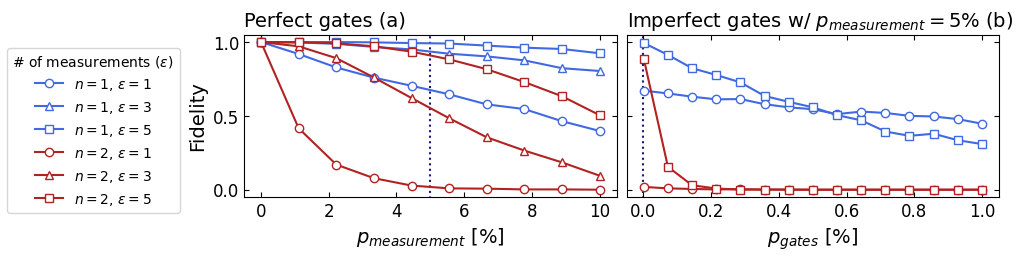

In [ ]:
#load data
with open('data/num_measurements.pkl', 'rb') as file:
    post_processed_num_measurements = pickle.load(file)

fig, axs = plt.subplots(1,2, figsize=(10,2.5), layout='constrained', sharey=True)
ax1, ax2 = axs

#Plot
h1, = ax1.plot(post_processed_num_measurements["variable_measurement_ps"]*100, post_processed_num_measurements["variable_measurement,1,1"], marker='o', color ='royalblue', markerfacecolor='w', label = r"$n=1$, $\varepsilon=1$")
h2, = ax1.plot(post_processed_num_measurements["variable_measurement_ps"]*100, post_processed_num_measurements["variable_measurement,1,3"], marker='^', color ='royalblue', markerfacecolor='w', label = r"$n=1$, $\varepsilon=3$")
h3, = ax1.plot(post_processed_num_measurements["variable_measurement_ps"]*100, post_processed_num_measurements["variable_measurement,1,5"], marker='s', color ='royalblue', markerfacecolor='w', label = r"$n=1$, $\varepsilon=5$")
h4, = ax1.plot(post_processed_num_measurements["variable_measurement_ps"]*100, post_processed_num_measurements["variable_measurement,2,1"], marker='o', color ='firebrick', markerfacecolor='w', label = r"$n=2$, $\varepsilon=1$")
h5, = ax1.plot(post_processed_num_measurements["variable_measurement_ps"]*100, post_processed_num_measurements["variable_measurement,2,3"], marker='^', color ='firebrick', markerfacecolor='w', label = r"$n=2$, $\varepsilon=3$")
h6, = ax1.plot(post_processed_num_measurements["variable_measurement_ps"]*100, post_processed_num_measurements["variable_measurement,2,5"], marker='s', color ='firebrick', markerfacecolor='w', label = r"$n=2$, $\varepsilon=5$")
ax1.plot([5,5],[-0.1,1.1], linestyle=':', color='midnightblue', zorder=-1000)

ax2.plot(post_processed_num_measurements["fixed_measurement_ps"]*100, post_processed_num_measurements["fixed_measurement,1,1"], marker='o', color ='royalblue', markerfacecolor='w', label = r"$n=1$, $\varepsilon=1$")
ax2.plot(post_processed_num_measurements["fixed_measurement_ps"]*100, post_processed_num_measurements["fixed_measurement,1,5"], marker='s', color ='royalblue', markerfacecolor='w', label = r"$n=1$, $\varepsilon=5$")
ax2.plot(post_processed_num_measurements["fixed_measurement_ps"]*100, post_processed_num_measurements["fixed_measurement,2,1"], marker='o', color ='firebrick', markerfacecolor='w', label = r"$n=2$, $\varepsilon=1$")
ax2.plot(post_processed_num_measurements["fixed_measurement_ps"]*100, post_processed_num_measurements["fixed_measurement,2,5"], marker='s', color ='firebrick', markerfacecolor='w', label = r"$n=2$, $\varepsilon=5$")
ax2.plot([0,0],[-0.1,1.1], linestyle=':', color='midnightblue', zorder=-1000)


#Style
for ax in axs:
    ax.tick_params(direction='in', left=True, right=True, top=True, bottom=True, labelsize=12)

ax1.set_xlabel("$p_{measurement}$ [%]", size = 14)
ax1.set_ylabel("Fidelity", size = 14)
ax1.set_title("Perfect gates (a)", size = 14, loc="left")
ax1.set_ylim(-0.05,1.05)

ax2.set_xlabel("$p_{gates}$ [%]", size = 14)
ax2.set_title(r"Imperfect gates, $p_{measurement} = 5\%$ (b)", size = 14, loc="left")

fig.legend(handles = [h1,h2,h3,h4,h5,h6], title=r"# of measurements ($\varepsilon$)", loc='outside left center')

#Save
#plt.tight_layout()
plt.savefig('figures/measuerements.pdf')


#

# Logical computations in the presence of gate errors.

In the next, consider a noise model in which there is probability $p$ of error on all gates. Two-qubit gates apply the error on both control and target qubit.

The case of ideal error correction and noisy error correction circuits are both considered.



In [207]:
#Define the noise model
def noise_model_generator(p_gate, p_cnot, noiseless_syndrome_measurement, num_qubits):
    error_single_qubit_gate = pauli_error([('I', 1-p_gate), ('X', p_gate/3), ('Y', p_gate/3), ('Z', p_gate/3)])
    error_cnot = pauli_error([('II', 1-p_cnot), ('XX', p_cnot/3), ('YY', p_cnot/3), ('ZZ', p_cnot/3)])

    noise_model = NoiseModel()
    if not noiseless_syndrome_measurement:
        noise_model.add_all_qubit_quantum_error(error_single_qubit_gate, ['h','x','y','z','s','sdg'])
        noise_model.add_all_qubit_quantum_error(error_cnot, ['cx'])
    else:
        noise_model.add_all_qubit_quantum_error(error_single_qubit_gate, ['h','x','y','z','s','sdg'])
        for i in range(num_qubits):
            for j in range(num_qubits):
                noise_model.add_quantum_error(error_cnot, ['cx'], [i, j])

    return noise_model

#Define method for getting input stabiliser for a circuit
def get_stabilizer(qc):
    aer = AerSimulator(method='stabilizer')
    qc = qc.copy()
    qc.save_stabilizer(label='s')
    return aer.run(qc, shots = 1).result().data()['s']

In [ ]:
ps = np.logspace(-7,0,20)
results_hadamard = dict()
shots = 1e3
i = 0

for noise_model in ["noiseless_error_correct","noisy_error_correct"]:
    for n, er in zip([0,1,2,2], [True, True, True, False]):
        sc = ShorCircuit([n], auto_encode=False)
        classical_register = ClassicalRegister(2000)
        sc.add_register(classical_register)
        
        #Get stabilizer for logical |+> state.
        h_qc = QuantumCircuit(9**n + 1)
        h_qc.h(0)
        encoder = ConcatenatedShorQubit(n).encoder()
        encoder.add_register(QuantumRegister(1)) #Add ancilla
        encoder.compose(h_qc, front=True, inplace=True)
        input_stabilizer = get_stabilizer(encoder)

        sc.set_stabilizer(input_stabilizer)
        sc.h(0, intermediate_error_correction=er)
        sc.error_correct(0)
        sc.save_stabilizer(label = 's', pershot = True)
        qc = sc.get_circuit(classical_register=classical_register)

        noise_model_gen = lambda p: noise_model_generator(p, p, noise_model == 'noiseless_error_correct', 9**n)

        experiment = NoiseModelExperiment(qc, noise_model_gen, ps, shots=shots, silent=False, method='stabilizer', basis_gates=['x','z','s','sdg','cx','h'])
        results_hadamard[f"{n},{er},{noise_model}"] = experiment.run()
        


In [6]:
post_processed_gates = dict()
for key, value in results_hadamard.items():
    encoder = ConcatenatedShorQubit(int(key[0])).encoder()
    encoder.add_register(QuantumRegister(1))
    ket_0_stabilizers = get_stabilizer(encoder)
    print(key)
    fidelities = [sum([s.equiv(ket_0_stabilizers) for s in res.data()['s']])/shots for res in value]
    post_processed_gates[key] = fidelities

with open('data/hadamard.pkl', 'wb') as file:
    pickle.dump(post_processed_gates, file)


0,True,noiseless_error_correct
1,True,noiseless_error_correct
2,True,noiseless_error_correct
2,False,noiseless_error_correct
0,True,noisy_error_correct
1,True,noisy_error_correct
2,True,noisy_error_correct
2,False,noisy_error_correct


In [208]:
#Simulate three different circuits with different error models
ps = np.logspace(-7,0,20) #-8 -6 still gave errors for n=2
results_only_error_correct = dict()
shots = 1e3
i = 0

for n in [0,1,2]:
    sc = ShorCircuit([n], auto_encode=False)
    classical_register = ClassicalRegister(2000)
    sc.add_register(classical_register)
    
    #Get stabilizer for logical |+> state.
    h_qc = QuantumCircuit(9**n + 1)
    h_qc.h(0)
    encoder = ConcatenatedShorQubit(n).encoder()
    encoder.add_register(QuantumRegister(1)) #Add ancilla
    encoder.compose(h_qc, front=True, inplace=True)
    input_stabilizer = get_stabilizer(encoder)

    sc.set_stabilizer(input_stabilizer)
    sc.error_correct(0)
    sc.save_stabilizer(label = 's', pershot = True)
    qc = sc.get_circuit(classical_register=classical_register)

    experiment = NoiseModelExperiment(qc, lambda p: noise_model_generator(p,p,False,9**n), ps, shots=shots, silent=False, method='stabilizer', basis_gates=['x','z','s','sdg','cx','h'])
    results_only_error_correct[f"{n}"] = experiment.run()
        


In [215]:
post_processed_only_error_correct = dict()
for key, value in results_only_error_correct.items():
    n = int(key[0])
    h_qc = QuantumCircuit(9**n + 1)
    h_qc.h(0)
    encoder = ConcatenatedShorQubit(n).encoder()
    encoder.add_register(QuantumRegister(1)) #Add ancilla
    encoder.compose(h_qc, front=True, inplace=True)
    ket_plus_stabilizer = get_stabilizer(encoder)
    print(key)
    fidelities = [sum([s.equiv(ket_plus_stabilizer) for s in res.data()['s']])/shots for res in value]
    post_processed_only_error_correct[key] = fidelities

with open('data/only_error_correct.pkl', 'wb') as file:
    pickle.dump(post_processed_only_error_correct, file)


0
1
2


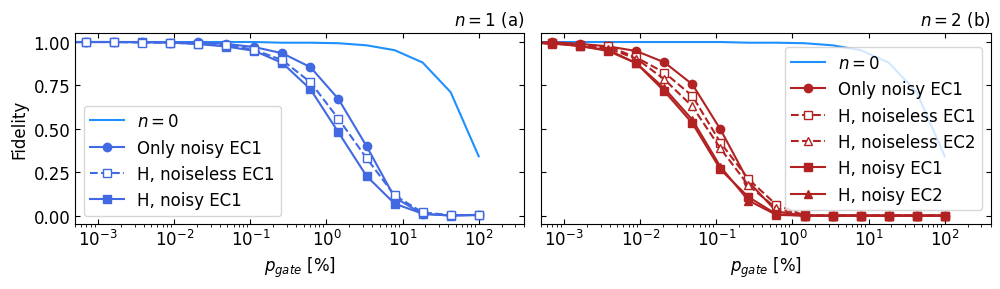

In [221]:
with open('data/hadamard.pkl', 'rb') as file:
    post_processed_gates = pickle.load(file)

with open('data/only_error_correct.pkl', 'rb') as file:
    post_processed_only_error_correct = pickle.load(file)


fig, axs = plt.subplots(1, 2, figsize=(10,3), sharey=True)
ps = np.logspace(-7,0,20)

ax1, ax2 = axs
ax1.plot(ps*100, post_processed_gates['0,True,noisy_error_correct'], color='dodgerblue', linestyle='-', label='$n=0$')
ax1.plot(ps*100, post_processed_only_error_correct['1'], color='royalblue', marker='o', linestyle='-', label='Only noisy EC1')
ax1.plot(ps*100, post_processed_gates['1,True,noiseless_error_correct'], color='royalblue', marker='s', markerfacecolor='w', linestyle='--', label='H, noiseless EC1')
ax1.plot(ps*100, post_processed_gates['1,True,noisy_error_correct'], color='royalblue', marker='s',linestyle='-',zorder=-5000, label='H, noisy EC1')

ax2.plot(ps*100, post_processed_gates['0,True,noisy_error_correct'], color='dodgerblue', linestyle='-', label='$n=0$')
ax2.plot(ps*100, post_processed_only_error_correct['2'], color='firebrick', marker='o', label='Only noisy EC1')
ax2.plot(ps*100, post_processed_gates['2,True,noiseless_error_correct'], color='firebrick',marker='s', linestyle='--', markerfacecolor='w', label='H, noiseless EC1')
ax2.plot(ps*100, post_processed_gates['2,False,noiseless_error_correct'], color='firebrick', marker='^', linestyle='--', markerfacecolor='w', label='H, noiseless EC2')
ax2.plot(ps*100, post_processed_gates['2,True,noisy_error_correct'], color='firebrick', marker='s', linestyle='-', label='H, noisy EC1')
ax2.plot(ps*100, post_processed_gates['2,False,noisy_error_correct'], color='firebrick', marker='^', linestyle='-', label='H, noisy EC2')

#Style
for ax in axs:
    ax.set_xscale('log')
    ax.tick_params(direction='in', left=True, right=True, top=True, bottom=True, labelsize=12)
    ax.set_xlabel('$p_{gate}$ [%]', size=12)
    ax.legend(fontsize=12)

ax1.set_title('$n=1$ (a)', loc='right', size=12)
ax2.set_title('$n=2$ (b)', loc='right', size=12)
ax1.set_ylabel('Fidelity', size=12)
ax1.set_xlim(5e-4,4e2)
ax2.set_xlim(5e-4,4e2)

fig.tight_layout()
fig.savefig('figures/hadamard_qc.pdf')
